In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy
import seaborn as sns

In [ ]:
# In[3]:


gland1 = 'MG'
gland2 = 'AG'
dataset = 'S-MAG'
celltype_column = 'newcelltype'
gland_column = 'gland'
n_top_genes=2000
dataset1 = 'S-MG'
dataset2 = 'S-AG'

# In[4]:


#adata = sc.read_h5ad(f"D:/111/{dataset}_cleaned.h5ad")  


# In[4]:


adata = sc.read_h5ad(f"../1.harmony/{dataset}_cleaned.h5ad")  


# In[5]:


adata.X = adata.layers['counts'].copy()


# In[ ]:
adata.obs['newcelltype'] = (adata.obs['newcelltype'].astype(str) + '-' +  adata.obs[gland_column].astype(str))

# In[ ]:


sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
#sc.pp.scale(adata, max_value=10)


# In[6]:


adata_A = adata[adata.obs[gland_column]==gland1]
adata_B = adata[adata.obs[gland_column]==gland2]


# In[7]:


adata_A


# In[8]:


cell_types_A = adata_A.obs[celltype_column].unique()
cell_types_B = adata_B.obs[celltype_column].unique()


# In[9]:


correlation_results = []

for celltype_A in cell_types_A:
    for celltype_B in cell_types_B:
        if celltype_A == celltype_B:
            continue

        print(f"current celltype: {celltype_A} vs {celltype_B}")

        # 选出 gland1 + celltype_A
        subset_gland1 = adata[
            (adata.obs[celltype_column] == celltype_A) &
            (adata.obs[gland_column] == gland1)
        ]

        # 选出 gland2 + celltype_B
        subset_gland2 = adata[
            (adata.obs[celltype_column] == celltype_B) &
            (adata.obs[gland_column] == gland2)
        ]

        # 确保子集非空
        if subset_gland1.shape[0] > 0 and subset_gland2.shape[0] > 0:
            # 直接将 NaN 替换为 0
            # 注意：这一步会改写 subset_gland1.X 和 subset_gland2.X 的底层数据
            subset_gland1.X = np.nan_to_num(subset_gland1.X, nan=0.0)
            subset_gland2.X = np.nan_to_num(subset_gland2.X, nan=0.0)

            # 重新计算均值表达向量
            mean_expression_gland1 = np.asarray(subset_gland1.X.mean(axis=0)).flatten()
            mean_expression_gland2 = np.asarray(subset_gland2.X.mean(axis=0)).flatten()

            # 计算 Spearman 相关及 p 值
            corr, pval = spearmanr(mean_expression_gland1, mean_expression_gland2,nan_policy='omit')

            correlation_results.append({
                'cell_type_A': celltype_A,
                'cell_type_B': celltype_B,
                'correlation': corr,
                'p-value': pval
            })

# 整理结果并过滤 p < 0.05
correlation_df = pd.DataFrame(correlation_results).dropna()
#correlation_df = correlation_df[correlation_df['p-value'] < 0.1]
print(correlation_df)


# In[ ]:


correlation_df.to_csv("correlation_results.csv", index=False)


# In[11]:


# ===== 绘制热图部分 =====
# 1) 将长表格 (long format) 转成矩阵形式 (wide format)
#    行为 cell_type_A，列为 cell_type_B，矩阵值为 correlation
correlation_matrix = correlation_df.pivot(
    index='cell_type_A',
    columns='cell_type_B',
    values='correlation'
)

# 2) 使用 matplotlib 绘制热图
fig, ax = plt.subplots()

# imshow 可以可视化二维数据；默认颜色映射即可
im = ax.imshow(correlation_matrix)

# 设置坐标轴刻度与标签
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.index)

# 让 X 轴标签旋转，防止重叠
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# 可选：在每个热图单元格中显示相关系数数值
for i in range(len(correlation_matrix.index)):
    for j in range(len(correlation_matrix.columns)):
        value = correlation_matrix.iloc[i, j]
        # 若该单元格不是 NaN，则绘制文字
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

# 添加颜色条
plt.colorbar(im)

# 设置标题
plt.title(f"Spearman Correlation Heatmap in {dataset}") 

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig(f"{dataset}-celltype_correlation_heatmap.png", dpi=300)

# 显示图片
plt.show()

# ===== 3) 若需要同时保存结果DataFrame =====
correlation_df.to_csv(f"{dataset}-celltype_correlation_results.csv", index=False)


# In[4]:


#correlation_df=pd.read_csv("./S-MAG-celltype_correlation_results.csv")
#correlation_df


# In[17]:


# 假设在脚本其他位置，你已获得 correlation_df，并且 import 了 matplotlib 等库

# 1) 提取并排序 cell_type_A / cell_type_B
unique_celltype_A = sorted(correlation_df['cell_type_A'].unique())
unique_celltype_B = sorted(correlation_df['cell_type_B'].unique())

# 2) 将 cell_type_A, cell_type_B 映射到数值索引
x_positions = correlation_df['cell_type_B'].apply(lambda x: unique_celltype_B.index(x))
y_positions = correlation_df['cell_type_A'].apply(lambda y: unique_celltype_A.index(y))

# 3) 颜色和点大小
colors = correlation_df['correlation'].values
sizes = 20 * -np.log10(correlation_df['p-value'] + 1e-16)

# --- 绘图开始 ---
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制散点图
scatter = ax.scatter(
    x_positions,
    y_positions,
    c=colors,
    s=sizes,
    cmap="jet",
    alpha=0.8
)

# 动态设置 colorbar 的取值范围
vmin, vmax = colors.min(), colors.max()
scatter.set_clim(vmin, vmax)

# 让右侧留足空间，方便放 colorbar 和 p-value 图例
plt.subplots_adjust(right=0.8)  # 可适当调大或调小

# 在右侧添加 colorbar（放在上方）
# - fraction: colorbar 相对于主绘图区 Axes 的长度比例（越小越短）
# - pad: colorbar 与 Axes 之间的空隙
# - shrink: 进一步全局缩短 colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.3, pad=0.02, shrink=0.5)
cbar.set_label("Spearman correlation coefficient", rotation=270, labelpad=10)

# 坐标轴刻度和标签
ax.set_xticks(range(len(unique_celltype_B)))
ax.set_yticks(range(len(unique_celltype_A)))
ax.set_xticklabels(unique_celltype_B, rotation=90)
ax.set_yticklabels(unique_celltype_A)
ax.set_xlabel("cell_type_B")
ax.set_ylabel("cell_type_A")

# p-value 图例（点大小说明），放在右下方
p_legend_values = [0.05, 0.01, 0.001]
handles, labels = [], []
for pval in p_legend_values:
    s = 20 * -np.log10(pval + 1e-16)
    handles.append(ax.scatter([], [], s=s, color='gray', alpha=0.8))
    labels.append(f"{pval:g}")

legend_title = "p-value"
ax.legend(
    handles,
    labels,
    title=legend_title,
    loc="lower right",       # 将图例放在主绘图区的右下角
    bbox_to_anchor=(1.5, 0),# (x=1.25)表示再向外留些空间，防止与图挤在一起
    frameon=False            # 去掉图例方框
)

# 标题与保存
plt.title(f"Dotplot of Spearman Correlation in {dataset}")
plt.tight_layout()
plt.savefig(f"{dataset}-celltype_correlation_dotplot.png", dpi=300)
plt.show()
# In[ ]:

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# import scanpy as sc
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr
# import scipy
# import seaborn as sns


# In[3]:


# gland1 = 'MG'
# gland2 = 'AG'
# dataset = 'S-MAG'
celltype_column = 'pse_stage'
# gland_column = 'gland'
n_top_genes=2000
path1=f"../../{dataset1}/9.stage_DEG/{dataset1}_cleaned_pse.h5ad"
path2=f"../../{dataset2}/9.stage_DEG/{dataset2}_cleaned_pse.h5ad"
vmin, vmax = 0.5, 0.9     
# In[4]:


adata1 = sc.read_h5ad(path1)
adata2 = sc.read_h5ad(path2)
adata1.obs = adata1.obs.drop(columns=["cellid"])
adata2.obs = adata2.obs.drop(columns=["cellid"])
adata = adata1.concatenate(adata2,batch_key = 'glandbatch')

adata.X = adata.layers['counts'].copy()

adata.obs['pse_stage'] = (adata.obs['pse_stage'].astype(str) + '-' +  adata.obs[gland_column].astype(str))

# In[ ]:


sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
#sc.pp.scale(adata, max_value=10)


# In[6]:


adata_A = adata[adata.obs[gland_column]==gland1]
adata_B = adata[adata.obs[gland_column]==gland2]



cell_types_A = adata_A.obs[celltype_column].unique()
cell_types_B = adata_B.obs[celltype_column].unique()


# In[9]:


correlation_results = []

for celltype_A in cell_types_A:
    for celltype_B in cell_types_B:
        if celltype_A == celltype_B:
            continue

        print(f"current celltype: {celltype_A} vs {celltype_B}")

        # 选出 gland1 + celltype_A
        subset_gland1 = adata[
            (adata.obs[celltype_column] == celltype_A) &
            (adata.obs[gland_column] == gland1)
        ]

        # 选出 gland2 + celltype_B
        subset_gland2 = adata[
            (adata.obs[celltype_column] == celltype_B) &
            (adata.obs[gland_column] == gland2)
        ]

        # 确保子集非空
        if subset_gland1.shape[0] > 0 and subset_gland2.shape[0] > 0:

            subset_gland1.X = np.nan_to_num(subset_gland1.X, nan=0.0)
            subset_gland2.X = np.nan_to_num(subset_gland2.X, nan=0.0)

            mean_expression_gland1 = np.asarray(subset_gland1.X.mean(axis=0)).flatten()
            mean_expression_gland2 = np.asarray(subset_gland2.X.mean(axis=0)).flatten()

            corr, pval = spearmanr(mean_expression_gland1, mean_expression_gland2,nan_policy='omit')
            correlation_results.append({
                'cell_type_A': celltype_A,
                'cell_type_B': celltype_B,
                'correlation': corr,
                'p-value': pval
            })

# 整理结果并过滤 p < 0.05
correlation_df = pd.DataFrame(correlation_results).dropna()
#correlation_df = correlation_df[correlation_df['p-value'] < 0.1]
print(correlation_df)


# In[ ]:


correlation_df.to_csv("correlation_results.csv", index=False)


# In[11]:

In [2]:
#correlation_df=pd.read_csv("./S-MAG-pse_correlation_results.csv")

NameError: name 'dataset' is not defined

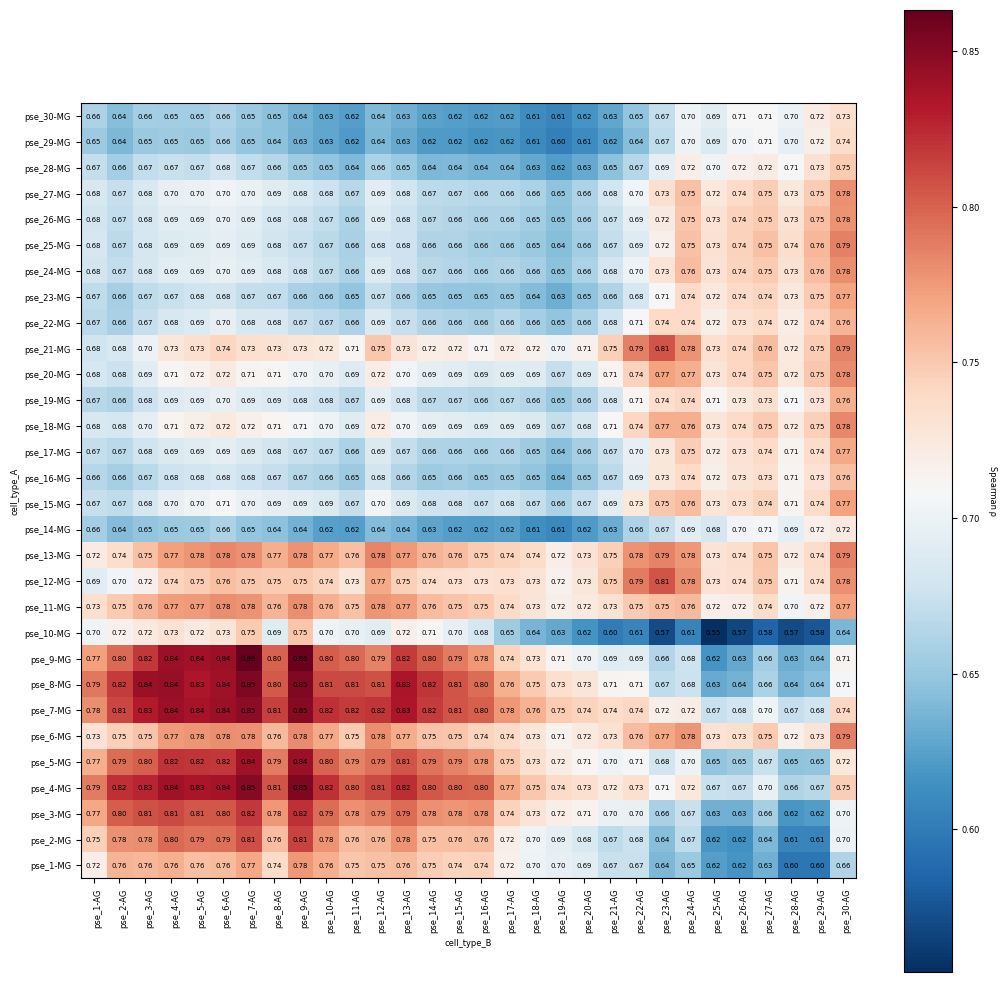

In [10]:
# ===== 绘制热图部分 =====
# 1) 将长表格 (long format) 转成矩阵形式 (wide format)
#    行为 cell_type_A，列为 cell_type_B，矩阵值为 correlation
correlation_matrix = correlation_df.pivot(
    index='cell_type_A',
    columns='cell_type_B',
    values='correlation'
)

import re

def _numeric_stage_sort(labels):
    """
    Sort labels like 'pse_1-MG', 'pse_12-AG' … by the numeric part between '_' and '-'.
    """
    def _key(s):
        m = re.search(r'_(\d+)(?:-|$)', s)
        return int(m.group(1)) if m else float('inf')
    return sorted(labels, key=_key)
    
# 1) 构造行列全集并按数字排序
stage_x = _numeric_stage_sort(correlation_df['cell_type_B'].unique())
stage_y = _numeric_stage_sort(correlation_df['cell_type_A'].unique())

# 2) 生成全矩阵并保持 NaN（方便 imshow 上写值时跳过）
corr_matrix = (correlation_df
               .pivot(index='cell_type_A', columns='cell_type_B', values='correlation')
               .reindex(index=stage_y, columns=stage_x))

# 3) 动态尺寸 & 字体
fig_w_hm = max(4, len(stage_x) * 0.35 + 2)
fig_h_hm = max(4, len(stage_y) * 0.35 + 2)
tick_font = max(6, 12 - 0.25 * max(len(stage_x), len(stage_y)))
title_font = max(10, 16 - 0.30 * max(len(stage_x), len(stage_y)))

# 4) 开始绘制
fig, ax = plt.subplots(figsize=(fig_w_hm, fig_h_hm))
im = ax.imshow(corr_matrix, cmap='RdBu_r')
im.set_clim(colors.min(), colors.max())
ax.invert_yaxis()
# 坐标轴
ax.set_xticks(np.arange(len(stage_x)))
ax.set_yticks(np.arange(len(stage_y)))
ax.set_xticklabels(stage_x, rotation=90, ha='right', rotation_mode='anchor', fontsize=tick_font)
ax.set_yticklabels(stage_y, fontsize=tick_font)

# 在每格写数值（跳过 NaN）
for i in range(len(stage_y)):
    for j in range(len(stage_x)):
        val = corr_matrix.iat[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                    color='black', fontsize=tick_font-1)

# 颜色条
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=tick_font)
cbar.set_label('Spearman ρ', rotation=270, labelpad=12, fontsize=tick_font)

# 标题与布局
ax.set_xlabel('cell_type_B', fontsize=tick_font)
ax.set_ylabel('cell_type_A', fontsize=tick_font)
plt.title(f'Spearman Correlation Heatmap in {dataset}', fontsize=title_font)
plt.tight_layout()
plt.savefig(f'{dataset}-pse_correlation_heatmap.png', dpi=300)
plt.show()
# ===== 3) 若需要同时保存结果DataFrame =====
correlation_df.to_csv(f"{dataset}-pse_correlation_results.csv", index=False)


# In[4]:


#correlation_df=pd.read_csv("./S-MAG-celltype_correlation_results.csv")
#correlation_df


# In[17]:


# 假设在脚本其他位置，你已获得 correlation_df，并且 import 了 matplotlib 等库

In [5]:
# 1) 提取并按数字排序 pse‑stage（cell_type_A / cell_type_B）
unique_celltype_A = _numeric_stage_sort(correlation_df['cell_type_A'].unique())
unique_celltype_B = _numeric_stage_sort(correlation_df['cell_type_B'].unique())

# 2) 映射到数值索引（横纵坐标）
x_positions = correlation_df['cell_type_B'].apply(lambda x: unique_celltype_B.index(x))
y_positions = correlation_df['cell_type_A'].apply(lambda y: unique_celltype_A.index(y))

# ------------------------------------------------------------------
# 根据 stage 数量动态计算画布 & 字体大小
# ------------------------------------------------------------------
max_stage = max(len(unique_celltype_A), len(unique_celltype_B))

#   尺寸：每个 stage 给 ~0.4 inch，外加 2 inch 边框，至少 4×4 inch
fig_w = max(4, len(unique_celltype_B) * 0.4 + 2)
fig_h = max(4, len(unique_celltype_A) * 0.4 + 2)

#   字体：stage 越多越缩小；最小 6 pt
tick_font  = max(6, 12 - 0.25 * max_stage)
title_font = max(10, 16 - 0.30 * max_stage)

# 3) 颜色 & 点大小
colors = correlation_df['correlation'].values
sizes  = 20 * -np.log10(correlation_df['p-value'] + 1e-16)

NameError: name 'dataset' is not defined

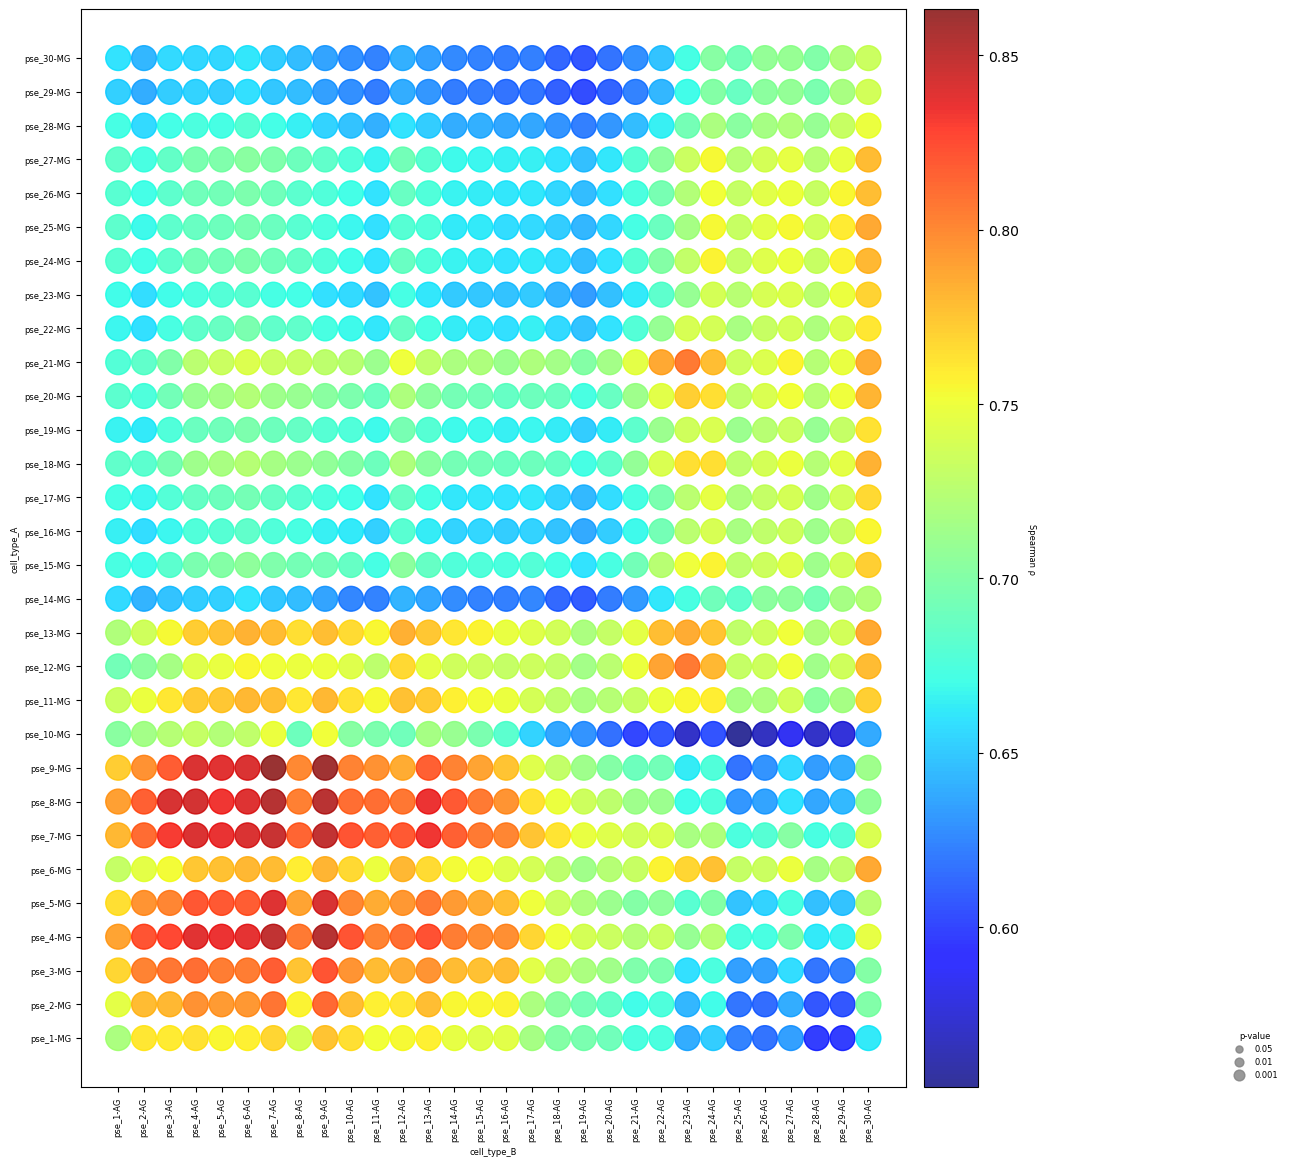

In [6]:
# ------------------------------------------------------------------
# Dot‑plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Scatter plot – give the limits directly …
sc = ax.scatter(
    x_positions, y_positions,
    c=colors, s=sizes,
    cmap='jet', alpha=0.8
)
sc.set_clim(vmin, vmax)

# 右侧留出空间放 colorbar & p‑value legend
plt.subplots_adjust(right=0.78)

# colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.08, pad=0.02)
cbar.set_label('Spearman ρ', rotation=270, labelpad=12, fontsize=tick_font)

# 坐标轴
ax.set_xticks(range(len(unique_celltype_B)))
ax.set_yticks(range(len(unique_celltype_A)))
ax.set_xticklabels(unique_celltype_B, rotation=90, fontsize=tick_font)
ax.set_yticklabels(unique_celltype_A, fontsize=tick_font)
ax.set_xlabel('cell_type_B', fontsize=tick_font)
ax.set_ylabel('cell_type_A', fontsize=tick_font)

# p‑value 大小图例
pvals = [0.05, 0.01, 0.001]
handles = [ax.scatter([], [], s=20 * -np.log10(p+1e-16),
                      color='gray', alpha=0.8) for p in pvals]
labels  = [f'{p:g}' for p in pvals]

ax.legend(
    handles, labels, title='p‑value',
    loc='lower right', bbox_to_anchor=(1.46, 0),
    frameon=False, fontsize=tick_font, title_fontsize=tick_font
)

ax.set_title(f'{dataset} | dot‑plot of stage correlations',
             fontsize=title_font, pad=20)
plt.tight_layout()
plt.savefig(f'{dataset}-pse_correlation_dotplot.png', dpi=300)
plt.savefig(f'{dataset}-pse_correlation_dotplot.pdf', dpi=300)
plt.close()